In [1]:
!pip install ta

Defaulting to user installation because normal site-packages is not writeable


In [1]:
import os

os.environ["TF_DETERMINISTIC_OPS"] = "1"
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# import ta
import nltk
from textblob import Word
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dropout, Dense, LSTM, GRU, RNN #can train using either GRU or LSTM
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout


from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from joblib import dump, load

/Users/kprakhar27/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/kprakhar27/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/kprakhar27/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [3]:
seed = 0

np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)

In [4]:
print(f"Current Working Directory: {os.getcwd()}")

print("Changing the directory to the project root directory...")
os.chdir("/Users/kprakhar27/Documents/NEU/FAI - Project/")

print(f"Current Working Directory: {os.getcwd()}")

Current Working Directory: /Users/kprakhar27/Documents/NEU/FAI - Project/src
Changing the directory to the project root directory...
Current Working Directory: /Users/kprakhar27/Documents/NEU/FAI - Project


In [5]:
DATA_DIR = "data"

DATA_URL = os.path.join(DATA_DIR, "fai_project_data.csv")

In [6]:
df = pd.read_csv(DATA_URL)

df.dropna(inplace=True)

required_cols = ["Date", "Close", "Open", "High", "Low", "Volume",
                 "Dividends", "Stock Splits", "Ticker", "Headlines"]
df = df[required_cols]

df['Date']= pd.to_datetime(df['Date'])

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2400 entries, 0 to 2543
Data columns (total 10 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          2400 non-null   datetime64[ns]
 1   Close         2400 non-null   float64       
 2   Open          2400 non-null   float64       
 3   High          2400 non-null   float64       
 4   Low           2400 non-null   float64       
 5   Volume        2400 non-null   int64         
 6   Dividends     2400 non-null   float64       
 7   Stock Splits  2400 non-null   float64       
 8   Ticker        2400 non-null   object        
 9   Headlines     2400 non-null   object        
dtypes: datetime64[ns](1), float64(6), int64(1), object(2)
memory usage: 206.2+ KB


In [8]:
df.head()

,Date,Close,Open,High,Low,Volume,Dividends,Stock Splits,Ticker,Headlines
0,2022-11-29,140.385330,143.487983,144.005097,139.569896,83763800,0.0,0.0,AAPL,"Stock Market Rally Awaits Fed Chief Powell, Ke..."
1,2022-11-30,147.207169,140.614017,147.893336,139.768751,111380900,0.0,0.0,AAPL,Elon Musk says Apple never considered removing...
2,2022-12-01,147.485626,147.386191,148.301076,145.795079,71250400,0.0,0.0,AAPL,Coinbase says Apple forced it to remove NFT wa...
3,2022-12-02,146.988403,145.148696,147.177350,144.840406,65447400,0.0,0.0,AAPL,Weekly Roundup | Apple (AAPL) Dips More Than B...
4,2022-12-05,145.814972,146.948635,150.081120,144.959752,68826400,0.0,0.0,AAPL,China’s protests made ‘enough of impact on par...


In [9]:
from abc import ABC, abstractmethod
from typing import List

class SentimentAnalyzer(ABC):
    """
    Abstract base class for sentiment analyzers.

    Attributes:
        None

    Methods:
        get_sentiment_scores: Abstract method to be implemented by subclasses for computing sentiment scores.

    """

    @abstractmethod
    def get_sentiment_scores(self, headlines: List[str]) -> float:
        """
        Abstract method to compute sentiment scores for a list of headlines.

        Parameters:
            headlines (List[str]): List of headlines for sentiment analysis.

        Returns:
            float: Sentiment score computed based on the provided headlines.

        """
        
        pass

In [10]:
from transformers import pipeline
from tqdm import tqdm

tqdm.pandas()

class HuggingFaceSentimentAnalyzer(SentimentAnalyzer):
    """
    Sentiment analyzer using the Hugging Face pipeline.

    Attributes:
        sentiment_pipeline: Hugging Face sentiment analysis pipeline.

    Methods:
        __init__: Constructor to initialize the HuggingFaceSentimentAnalyzer.
        get_sentiment_scores: Implementation of the abstract method for sentiment analysis.

    """

    def __init__(self):
        """
        Constructor to initialize the HuggingFaceSentimentAnalyzer.

        Parameters:
            None

        Returns:
            None

        """
        
        self.sentiment_pipeline = pipeline("sentiment-analysis")

    def get_sentiment_scores(self, headlines) -> float:
        """
        Compute sentiment scores for a list of headlines using the Hugging Face pipeline.

        Parameters:
            headlines (str): Pipe-separated string of headlines for sentiment analysis.

        Returns:
            float: Sentiment score computed based on the provided headlines.

        """
        
        # Split the pipe-separated string of headlines into a list
        headlines = headlines.split("|")

        chunk = ""
        headline_chunks = []

        # Divide the headlines into chunks to avoid exceeding the maximum token limit
        for i, headline in enumerate(headlines, 1):
            if len(chunk + ". " + headline) < np.power(2, 32):
                chunk += ". " + headline
            else:
                headline_chunks.append(chunk)
                chunk = ""

        running_sum = 0

        # Process each chunk of headlines and accumulate sentiment scores
        for headline in headline_chunks:
            result = self.sentiment_pipeline(headline)[0]

            label = result['label']
            score = result['score']

            if label == 'NEGATIVE':
                score = -1 * score

            running_sum += score

        # Compute the average sentiment score across all headlines
        return running_sum / len(headlines)

In [11]:
from transformers import pipeline
from tqdm import tqdm

tqdm.pandas()

class FinBERTSentimentAnalyzer(SentimentAnalyzer):
    """
    Sentiment analyzer using the FinBERT model.

    Attributes:
        sentiment_pipeline: Hugging Face pipeline with FinBERT model.

    Methods:
        __init__: Constructor to initialize the FinBERTSentimentAnalyzer.
        get_sentiment_scores: Implementation of the abstract method for sentiment analysis.
    """

    def __init__(self):
        """
        Constructor to initialize the FinBERTSentimentAnalyzer.

        Parameters:
            None

        Returns:
            None
        """
        
        self.sentiment_pipeline = pipeline("text-classification", model="ProsusAI/finbert")

    def get_sentiment_scores(self, headlines) -> float:
        """
        Compute sentiment scores for a list of headlines using the FinBERT model.

        Parameters:
            headlines (str): Pipe-separated string of headlines for sentiment analysis.

        Returns:
            float: Sentiment score computed based on the provided headlines.
        """
        
        # Split the pipe-separated string of headlines into a list
        headlines = headlines.split("|")

        chunk = ""
        headline_chunks = []

        # Divide the headlines into chunks to avoid exceeding the maximum token limit
        for i, headline in enumerate(headlines, 1):
            if len(chunk + ". " + headline) < np.power(2, 32):
                chunk += ". " + headline
            else:
                headline_chunks.append(chunk)
                chunk = ""

        running_sum = 0

        # Process each chunk of headlines and accumulate sentiment scores
        for headline in headline_chunks:
            result = self.sentiment_pipeline(headline)[0]

            label = result['label']
            score = result['score']

            if label == 'NEGATIVE':
                score = -1 * score

            running_sum += score

        # Compute the average sentiment score across all headlines
        return running_sum / len(headlines)

In [12]:
from textblob import TextBlob

class TextBlobSentimentAnalyzer(SentimentAnalyzer):
    """
    Sentiment analyzer using the TextBlob library.
    """

    def __init__(self):
        pass

    def get_sentiment_scores(self, headlines) -> float:
        """
        Compute sentiment scores for a text using the TextBlob library.

        Parameters:
            headlines (str): Text for sentiment analysis.

        Returns:
            float: Sentiment score computed based on the provided text.
        """
        
        # Create a TextBlob object from the provided text
        text_blob = TextBlob(headlines)

        # Retrieve the sentiment polarity score
        sentiment_score = text_blob.sentiment.polarity

        return sentiment_score

In [13]:
class CustomSentimentAnalyzer1(SentimentAnalyzer):
    """
    Custom trained sentiment analyzer for sentiment analysis.

    Attributes:
        max_words (int): Maximum number of words to tokenize.
        max_sequence_length (int): Maximum sequence length for padding.
        model: The pre-trained sentiment analysis model.

    Methods:
        inference_cleaning: Pre-processing function for cleaning text data during inference.
        preprocess_inference_data: Preprocess inference data for the model.
        get_predictions: Get sentiment predictions using the pre-trained model.
        get_sentiment_scores: Implementation of the abstract method for sentiment analysis.
    """

    def __init__(self):
        self.max_words = 5000  # Maximum number of words to tokenize
        self.max_sequence_length = 100  # Maximum sequence length for padding
        self.model = None  # Placeholder for the pre-trained model

    def inference_cleaning(self, headlines, stop_words):
        """
        Pre-processing function for cleaning text data during inference.

        Parameters:
            headlines (str): Text data for inference.
            stop_words (List[str]): List of stop words.

        Returns:
            str: Cleaned and pre-processed text data.
        """
        
        headlines = ' '.join(x.lower() for x in str(headlines).split())

        # Replacing the digits/numbers
        headlines = headlines.replace('d', '')

        # Removing stop words
        headlines = ' '.join(x for x in str(headlines).split() if x not in stop_words)

        # Lemmatization
        headlines = ' '.join([Word(headlines).lemmatize() for x in str(headlines).split()])

        return headlines

    def preprocess_inference_data(self, data):
        """
        Preprocess inference data for the model.

        Parameters:
            data (str): Text data for inference.

        Returns:
            np.ndarray: Processed and tokenized data ready for model input.
        """
        
        stop_words = stopwords.words('english')
        data = self.inference_cleaning(data, stop_words)

        data = np.array([data])

        # Preprocess the text data
        tokenizer = Tokenizer(num_words=self.max_words, oov_token='<OOV>')
        tokenizer.fit_on_texts(data)

        X = tokenizer.texts_to_sequences(data)
        X = pad_sequences(X, maxlen=self.max_sequence_length, padding='post', truncating='post')

        return X

    def get_predictions(self, data):
        """
        Get sentiment predictions using the pre-trained model.

        Parameters:
            data (str): Text data for inference.

        Returns:
            np.ndarray: Model predictions for sentiment analysis.
        """
        
        self.model = tf.keras.models.load_model('custom_nlp1.keras')

        X_test = self.preprocess_inference_data(data)

        # Evaluate the model
        predictions = self.model.predict(X_test)

        return predictions

    def get_sentiment_scores(self, headlines) -> float:
        """
        Implementation of the abstract method for sentiment analysis.

        Parameters:
            headlines (str): Text data for sentiment analysis.

        Returns:
            float: Sentiment score computed based on the provided text data.
        """
        
        return self.get_predictions(headlines)

In [ ]:
from pandas.tseries.holiday import USFederalHolidayCalendar
from pandas.tseries.offsets import CustomBusinessDay
from sklearn.metrics import mean_squared_error
from typing import Optional

class MultivariateTimeSeriesModel(object):
    """
    Class for building and training a multivariate time series model.

    Attributes:
        stock_data (pd.DataFrame): DataFrame containing stock data.
        sentiment_analyzer (Optional[SentimentAnalyzer]): Optional sentiment analyzer.
        is_custom_sentiment_analyzer (bool): Flag indicating whether a custom sentiment analyzer is used.
        model (str): Type of model to use (default is "GRU").

    Methods:
        data_preprocessing: Preprocess stock data for model training.
        get_GRU_model: Build a GRU model architecture.
        get_LSTM_model: Build an LSTM model architecture.
        get_RNN_model: Build an RNN model architecture.
        get_model: Get the selected model architecture.
        compile_model: Compile the model with optimizer and loss function.
        train_model: Train the model on the provided data.
        run_inference: Run inference on the model for future predictions.

    """

    def __init__(self, stock_data: pd.DataFrame, model: str = "GRU",
                 is_custom_sentiment_analyzer: bool = False,
                 sentiment_analyzer: Optional[SentimentAnalyzer] = None):
        """
        Constructor to initialize the MultivariateTimeSeriesModel.

        Parameters:
            stock_data (pd.DataFrame): DataFrame containing stock data.
            model (str): Type of model to use (default is "GRU").
            is_custom_sentiment_analyzer (bool): Flag indicating whether a custom sentiment analyzer is used.
            sentiment_analyzer (Optional[SentimentAnalyzer]): Optional sentiment analyzer.

        """
        self.stock_data = stock_data
        self.sentiment_analyzer = sentiment_analyzer
        self.is_custom_sentiment_analyzer = is_custom_sentiment_analyzer
        self.model = model

    def data_preprocessing(self, df):
        """
        Preprocess stock data for model training.

        Parameters:
            df (pd.DataFrame): DataFrame containing stock data.

        Returns:
            Tuple[np.ndarray, np.ndarray, pd.DataFrame]: Processed input data, output data, and processed DataFrame.

        """
        cols = ["Date", "Open", "High", "Low", "Close"]

        # Include sentiment feature if sentiment analyzer is provided
        if self.sentiment_analyzer:
            df["sentiment"] = df["Headlines"].progress_apply(self.sentiment_analyzer.get_sentiment_scores)
            cols.append("sentiment")

        stock_data = df[cols]

        # Convert the Date column to DateTime from Object type
        set_dates = pd.to_datetime(stock_data['Date'])
        set_dates.head()

        # Extract the required features, omitting the volume if sentiment analyzer is used
        if self.sentiment_analyzer:
            columns = list(stock_data.columns[1:6])
        else:
            columns = list(stock_data.columns[1:5])

        processed_df = stock_data[columns].astype(float)
        processed_df.head()

        # Normalize the data using the Standard scaler
        self.standard_scaler = StandardScaler()
        self.standard_scaler = self.standard_scaler.fit(processed_df)
        scaled_training_df = self.standard_scaler.transform(processed_df)

        X = []
        Y = []

        future_no_of_days = 1  # Number of days to predict the future values
        past_no_of_days = 14  # Number of days on which the prediction is computed

        # Create input sequences and corresponding output values
        for i in range(past_no_of_days, len(scaled_training_df) - future_no_of_days + 1):
            X.append(scaled_training_df[i - past_no_of_days:i, 0:processed_df.shape[1]])
            Y.append(scaled_training_df[i + future_no_of_days - 1:i + future_no_of_days, 0])

        X, Y = np.array(X), np.array(Y)

        self.X = X

        print('X shape: {}'.format(X.shape))
        print('Y shape: {}'.format(Y.shape))

        return X, Y, processed_df

    @staticmethod
    def get_GRU_model(X_shape_1, X_shape_2, Y_shape):
        """
        Build a GRU model architecture.

        Parameters:
            X_shape_1 (int): Shape of the first dimension of input data.
            X_shape_2 (int): Shape of the second dimension of input data.
            Y_shape (int): Shape of the output data.

        Returns:
            tf.keras.Sequential: GRU model.

        """
        model = Sequential()
        model.add(GRU(64, activation='relu', input_shape=(X_shape_1, X_shape_2), return_sequences=True))
        model.add(GRU(32, activation='relu', return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(Y_shape))

        return model

    @staticmethod
    def get_LSTM_model(X_shape_1, X_shape_2, Y_shape):
        """
        Build an LSTM model architecture.

        Parameters:
            X_shape_1 (int): Shape of the first dimension of input data.
            X_shape_2 (int): Shape of the second dimension of input data.
            Y_shape (int): Shape of the output data.

        Returns:
            tf.keras.Sequential: LSTM model.

        """
        model = Sequential()
        model.add(LSTM(64, input_shape=(X_shape_1, X_shape_2), return_sequences=True))
        model.add(LSTM(32, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(Y_shape))

        return model

    @staticmethod
    def get_RNN_model(X_shape_1, X_shape_2, Y_shape):
        """
        Build an RNN model architecture.

        Parameters:
            X_shape_1 (int): Shape of the first dimension of input data.
            X_shape_2 (int): Shape of the second dimension of input data.
            Y_shape (int): Shape of the output data.

        Returns:
            tf.keras.Sequential: RNN model.

        """
        model = Sequential()
        model.add(RNN(64, input_shape=(X_shape_1, X_shape_2), return_sequences=True))
        model.add(RNN(32, return_sequences=False))
        model.add(Dropout(0.2))
        model.add(Dense(Y_shape))

        return model

    def get_model(self, trainX, trainY):
        """
        Get the selected model architecture.

        Parameters:
            trainX (np.ndarray): Input training data.
            trainY (np.ndarray): Output training data.

        Returns:
            tf.keras.Sequential: Selected model architecture.

        """
        X_shape_1 = trainX.shape[1]
        X_shape_2 = trainX.shape[2]
        Y_shape = trainY.shape[1]

        if self.model == "GRU":
            model = self.get_GRU_model(X_shape_1, X_shape_2, Y_shape)
        elif self.model == "LSTM":
            model = self.get_LSTM_model(X_shape_1, X_shape_2, Y_shape)
        else:
            model = self.get_RNN_model(X_shape_1, X_shape_2, Y_shape)

        model.summary()
        return model

    def compile_model(self, optimizer, loss):
        """
        Compile the model with optimizer and loss function.

        Parameters:
            optimizer (str): Optimizer for model compilation.
            loss (str): Loss function for model compilation.
        """
        self.model.compile(optimizer=optimizer, loss=loss)

    def train_model(self):
        """
        Train the model on the provided data.
        """
        trainX, trainY, df_train = self.data_preprocessing(self.stock_data)

        self.model = self.get_model(trainX, trainY)
        self.compile_model(optimizer="adam", loss="mse")

        # Fit the model
        history = self.model.fit(trainX, trainY, epochs=10, batch_size=16, validation_split=0.1, verbose=1)

        # Plot training and validation loss
        plt.figure(figsize=(12, 8))
        plt.plot(history.history['loss'], label='Training loss')
        plt.plot(history.history['val_loss'], label='Validation loss')
        plt.legend()
        plt.show()

    def run_inference(self, test_df):
        """
        Run inference on the model for future predictions.

        Parameters:
            test_df (pd.DataFrame): DataFrame containing test data.

        Returns:
            Tuple[pd.DataFrame, pd.DataFrame]: Original and forecasted stock data.

        """
        us_business_days = CustomBusinessDay(calendar=USFederalHolidayCalendar())

        n_past = 90
        n_days_for_prediction = 90  # Predict past 15 days

        # Convert the Date column to DateTime from Object type
        test_set_dates = pd.to_datetime(test_df['Date'])
        test_set_dates.head()

        # Define prediction period dates
        predict_period_dates = pd.date_range(
            list(test_set_dates)[-n_past], periods=n_days_for_prediction,
            freq=us_business_days
        ).tolist()

        testX, testY, df_test = self.data_preprocessing(test_df)

        # Make prediction
        prediction = self.model.predict(testX[-n_days_for_prediction:])  # Shape = (n, 1) where n is n_days_for_prediction

        # Predict the future price
        prediction_copies = np.repeat(prediction, df_test.shape[1], axis=-1)
        y_pred_future = self.standard_scaler.inverse_transform(prediction_copies)[:, 0]

        # Convert timestamp to date
        forecast_dates = [time_i.date() for time_i in predict_period_dates]

        df_forecast = pd.DataFrame({'Date': np.array(forecast_dates), 'Close': y_pred_future})
        df_forecast['Date'] = pd.to_datetime(df_forecast['Date'])

        original = test_df[['Date', 'Close']]
        original['Date'] = pd.to_datetime(original['Date'])
        original = original.loc[original['Date'] >= df_forecast.Date.min()]  # Selecting data only from 2022 for convenience

        mse = mean_squared_error(original["Close"], df_forecast["Close"])
        print(f"Mean Squared Error: {mse}")

        return original, df_forecast

In [15]:
df.head()

,Date,Close,Open,High,Low,Volume,Dividends,Stock Splits,Ticker,Headlines
0,2022-11-29,140.385330,143.487983,144.005097,139.569896,83763800,0.0,0.0,AAPL,"Stock Market Rally Awaits Fed Chief Powell, Ke..."
1,2022-11-30,147.207169,140.614017,147.893336,139.768751,111380900,0.0,0.0,AAPL,Elon Musk says Apple never considered removing...
2,2022-12-01,147.485626,147.386191,148.301076,145.795079,71250400,0.0,0.0,AAPL,Coinbase says Apple forced it to remove NFT wa...
3,2022-12-02,146.988403,145.148696,147.177350,144.840406,65447400,0.0,0.0,AAPL,Weekly Roundup | Apple (AAPL) Dips More Than B...
4,2022-12-05,145.814972,146.948635,150.081120,144.959752,68826400,0.0,0.0,AAPL,China’s protests made ‘enough of impact on par...


In [16]:
df.Ticker.unique()

train_tickers = ["AAPL", "ABNB", "COIN", "META", "MRNA", "NVDA", "PLTR", "AMZN", "TSLA"]
# train_tickers = ["AAPL", "META", "AMZN"]
# train_tickers = ["AAPL"]
test_tickers = ["GOOG"]

train_df = df[df["Ticker"].isin(train_tickers)]
test_df = df[df["Ticker"].isin(test_tickers)]

In [24]:
# RNN without sentiment analysis

# mv_ts_model = MultivariateTimeSeriesModel(train_df, model="RNN")

# RNN with HuggingFace sentiment analysis

# mv_ts_model = MultivariateTimeSeriesModel(train_df, model="RNN", sentiment_analyzer=HuggingFaceSentimentAnalyzer())

# RNN with TextBlob sentiment analysis
# mv_ts_model = MultivariateTimeSeriesModel(train_df, model="RNN", sentiment_analyzer=TextBlobSentimentAnalyzer())

# mv_ts_model = MultivariateTimeSeriesModel(train_df, model="RNN", sentiment_analyzer=CustomSentimentAnalyzer1())

# mv_ts_model = MultivariateTimeSeriesModel(train_df, model="RNN", is_custom_sentiment_analyzer=True)

In [17]:
# GRU without sentiment analysis

# mv_ts_model = MultivariateTimeSeriesModel(train_df, model="GRU")

# GRU with HuggingFace sentiment analysis

# mv_ts_model = MultivariateTimeSeriesModel(train_df, model="GRU", sentiment_analyzer=HuggingFaceSentimentAnalyzer())

# mv_ts_model = MultivariateTimeSeriesModel(train_df, model="GRU", sentiment_analyzer=FinBERTSentimentAnalyzer())

# GRU with TextBlob sentiment analysis
mv_ts_model = MultivariateTimeSeriesModel(train_df, model="GRU", sentiment_analyzer=TextBlobSentimentAnalyzer())

# mv_ts_model = MultivariateTimeSeriesModel(train_df, model="GRU", is_custom_sentiment_analyzer=True)

# mv_ts_model = MultivariateTimeSeriesModel(train_df, model="GRU", sentiment_analyzer=CustomSentimentAnalyzer1())

In [26]:
# LSTM without sentiment analysis

# mv_ts_model = MultivariateTimeSeriesModel(train_df, model="LSTM")

# LSTM with HuggingFace sentiment analysis

# mv_ts_model = MultivariateTimeSeriesModel(train_df, model="LSTM", sentiment_analyzer=HuggingFaceSentimentAnalyzer())

# LSTM with TextBlob sentiment analysis
# mv_ts_model = MultivariateTimeSeriesModel(train_df, model="LSTM", sentiment_analyzer=TextBlobSentimentAnalyzer())

# mv_ts_model = MultivariateTimeSeriesModel(train_df, model="LSTM", is_custom_sentiment_analyzer=True)

100%|████████████████████████████████████| 2159/2159 [00:00<00:00, 24622.53it/s]

X shape: (2145, 14, 5)
Y shape: (2145, 1)



/var/folders/h6/k8vv50fn5sl3snld_mq4dwf00000gn/T/ipykernel_21675/799181638.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment"] = df["Headlines"].progress_apply(self.sentiment_analyzer.get_sentiment_scores)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 14, 64)            13632     
                                                                 
 gru_1 (GRU)                 (None, 32)                9408      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 23073 (90.13 KB)
Trainable params: 23073 (90.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/10
121/121 [==============================] - 60s 450ms/step - loss: 0.1357 - val_loss: 0.0082
Epoch 2/10
121/121 [=============================

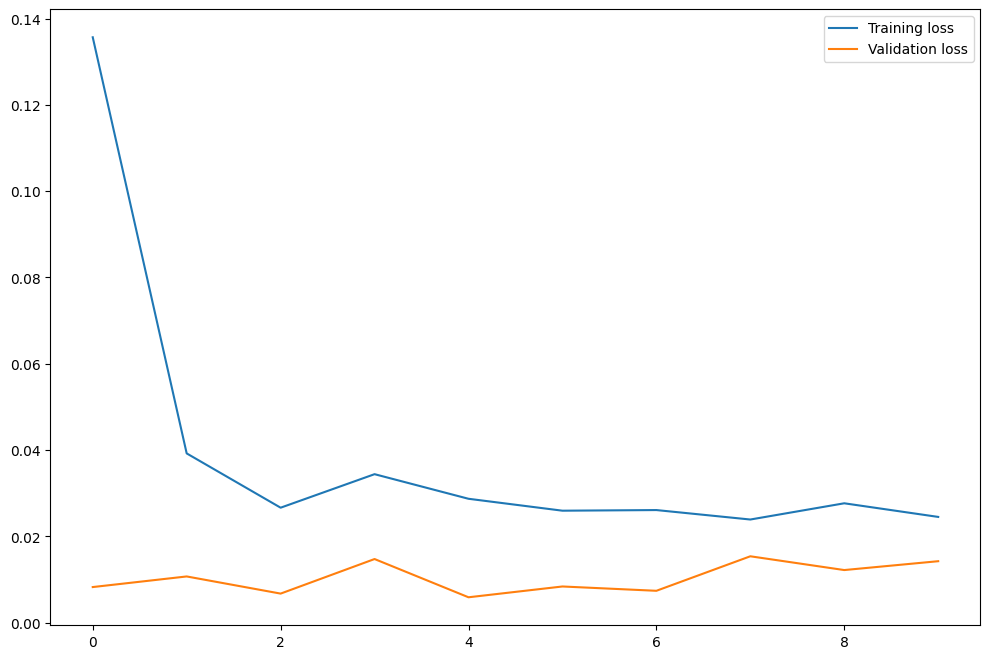

In [18]:
mv_ts_model.train_model()

In [19]:
y_true, y_pred = mv_ts_model.run_inference(test_df)

100%|██████████████████████████████████████| 241/241 [00:00<00:00, 19487.33it/s]
/var/folders/h6/k8vv50fn5sl3snld_mq4dwf00000gn/T/ipykernel_21675/799181638.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["sentiment"] = df["Headlines"].progress_apply(self.sentiment_analyzer.get_sentiment_scores)


X shape: (227, 14, 5)
Y shape: (227, 1)
3/3 [==============================] - 3s 765ms/step
Mean Squared Error: 14.886343242718269


/var/folders/h6/k8vv50fn5sl3snld_mq4dwf00000gn/T/ipykernel_21675/799181638.py:174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  original['Date']=pd.to_datetime(original['Date'])


In [ ]:
mv_ts_model = MultivariateTimeSeriesModel(train_df, model="GRU")

mv_ts_model.train_model()

In [ ]:
y_true_without_sent, y_pred_without_sent = mv_ts_model.run_inference(test_df)

In [ ]:
plt.figure(figsize=(12,8))

# sns.lineplot(data=y_pred, x='Date', y='Close', label="Predicted Stock Price with sentiment")
sns.lineplot(data=y_pred_without_sent, x='Date', y='Close', label="Predicted Stock Price without sentiment")
sns.lineplot(data=y_true, x='Date', y='Close', label="Actual Stock Price")

plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Google, Inc Stock Price Inference")

plt.show()

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns  # Assuming you are using seaborn for plotting

plt.figure(figsize=(12, 6))

# Create subplot with 1 row and 2 columns, and select the first column
plt.subplot(1, 2, 1)

# Plot the first line
sns.lineplot(data=y_true, x='Date', y='Close', label="Actual Stock Price")
sns.lineplot(data=y_pred_without_sent, x='Date', y='Close', label="Predicted Stock Price without sentiment")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Predicted Stock Price without sentiment")

plt.xticks(rotation=45)

# Move to the second column
plt.subplot(1, 2, 2)

# Plot the second line
sns.lineplot(data=y_true, x='Date', y='Close', label="Actual Stock Price")
sns.lineplot(data=y_pred, x='Date', y='Close', label="Predicted Stock Price with sentiment")
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Actual Stock Price")

plt.xticks(rotation=45)

# Adjust layout for better spacing
plt.tight_layout()

# Show the plot
plt.show()
